In [2]:
#Installations préalables
%pip install lxml
%pip install pandas
%pip install geopandas
%pip install matplotlib
%pip install requests
%pip install bs4
%pip install nltk
%pip install seaborn
%pip install plotly
%pip install tqdm
%pip install pywaffle
%pip install spacy
%pip install plotnine
%pip install great_tables
%pip install wordcloud
%pip install country_converter
%pip install nbformat

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pandas in c:\users\natha\miniconda3\lib\site-packages (2.2.2)



Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: geopandas in c:\users\natha\miniconda3\lib\site-packages (1.0.1)



Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import country_converter as coco
import plotly.express as px
import seaborn as sns
%run "src/scripts/billboards.py"
%run "src/scripts/musicbrainz.py"
%run "src/scripts/genius.py"

In [4]:
dataframe = get_billboard_hits()

# Flatten the list of artists
all_artists = [artist for sublist in dataframe['Artist'] for artist in sublist]

# Count the occurrences of each artist
artist_counts = pd.Series(all_artists).value_counts()

dataframe

,Song,Artist
0,APT.,"[Rosé, Bruno Mars]"
1,All I Want For Christmas Is You,[Mariah Carey]
2,Last Christmas,[Wham!]
3,Die With A Smile,"[Lady Gaga, Bruno Mars]"
4,Rockin' Around The Christmas Tree,[Brenda Lee]
...,...,...
195,Something Just Like This,"[The Chainsmokers, Coldplay]"
196,Dodger Blue,"[Kendrick Lamar, Wallie the Sensei, Siete7x, R..."
197,Counting Stars,[OneRepublic]
198,Lovely,"[Billie Eilish, Khalid]"


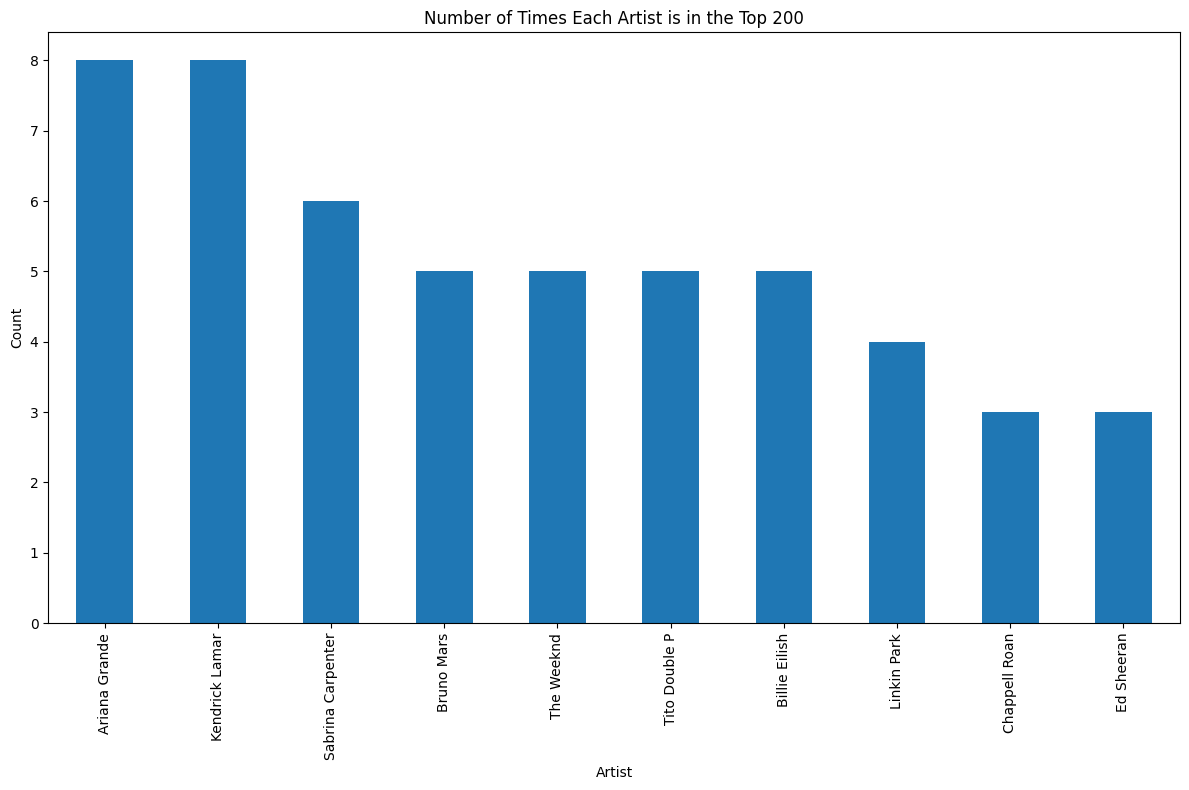

In [5]:
# Plot the data
plt.figure(figsize=(12, 8))
artist_counts.head(10).plot(kind='bar')
plt.title('Number of Times Each Artist is in the Top 200')
plt.xlabel('Artist')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [6]:
df_artists = fetch_artist_data(all_artists)
        
df_artists

  0%|          | 0/255 [00:00<?, ?it/s]

  4%|▍         | 10/255 [00:20<08:28,  2.07s/it]

No artist data found.


 35%|███▌      | 90/255 [03:08<05:44,  2.09s/it]

No artist information found.


 38%|███▊      | 98/255 [03:24<05:11,  1.98s/it]

No artist data found.


 46%|████▋     | 118/255 [04:03<04:18,  1.89s/it]

No artist data found.


 53%|█████▎    | 134/255 [04:35<04:04,  2.02s/it]

No artist information found.


 64%|██████▍   | 164/255 [05:37<03:05,  2.04s/it]

No artist information found.


 75%|███████▌  | 192/255 [06:31<02:01,  1.92s/it]

No artist information found.


 91%|█████████ | 232/255 [07:49<00:46,  2.00s/it]

No artist data found.


 99%|█████████▉| 253/255 [08:33<00:04,  2.15s/it]

No artist data found.


100%|██████████| 255/255 [08:37<00:00,  2.03s/it]


,Artist,Country,Type,Gender,Rating,Tags
0,ROSÉ,KR,Person,Female,"{'votes-count': 1, 'value': 5}","[{'count': 2, 'name': 'k-pop'}, {'count': 1, '..."
1,Bruno Mars,US,Person,Male,"{'value': 3.75, 'votes-count': 4}","[{'name': '2010s', 'count': 1}, {'name': 'funk..."
2,Mariah Carey,US,Person,Female,"{'value': 4.4, 'votes-count': 13}","[{'name': '1990s', 'count': 1}, {'name': '2000..."
3,Wham!,GB,Group,None,"{'value': 4.65, 'votes-count': 3}","[{'name': 'christmas music', 'count': 1}, {'na..."
4,Lady Gaga,US,Person,Female,"{'value': 4.25, 'votes-count': 21}","[{'name': '2000s', 'count': 1}, {'count': 2, '..."
...,...,...,...,...,...,...
249,Roddy Ricch,US,Person,Male,"{'value': None, 'votes-count': 0}","[{'name': 'english', 'count': 1}, {'name': 'hi..."
250,OneRepublic,US,Group,None,"{'value': 3, 'votes-count': 3}","[{'count': 1, 'name': 'folk pop'}, {'name': 'p..."
251,Billie Eilish,US,Person,Female,"{'votes-count': 9, 'value': 3.65}","[{'name': '2010s', 'count': 1}, {'name': '2020..."
252,Khalid,US,Person,Male,"{'value': None, 'votes-count': 0}","[{'count': 3, 'name': 'contemporary r&b'}, {'c..."


In [7]:
# Divide the 'Rating' column in two (value and count)
df_artists['RatingValue'] = df_artists['Rating'].apply(lambda x: x.get('value') if x else None)
df_artists['RatingCount'] = df_artists['Rating'].apply(lambda x: x.get('votes-count') if x else None)

# Remove the 'Rating' column
df_artists.drop(columns=['Rating'], inplace=True)

# Simplify the 'Tags' column (keep only the names)
df_artists['Tags'] = df_artists['Tags'].apply(lambda x: [tag['name'] for tag in x] if x else None)

df_artists

,Artist,Country,Type,Gender,Tags,RatingValue,RatingCount
0,ROSÉ,KR,Person,Female,"[k-pop, korean ballad]",5.00,1
1,Bruno Mars,US,Person,Male,"[2010s, funk, music for soccer moms, pop, r&b,...",3.75,4
2,Mariah Carey,US,Person,Female,"[1990s, 2000s, 90s, adult contemporary, christ...",4.40,13
3,Wham!,GB,Group,None,"[christmas music, dance-pop, pop, queer]",4.65,3
4,Lady Gaga,US,Person,Female,"[2000s, 2010s, 2020s, adult contemporary, amer...",4.25,21
...,...,...,...,...,...,...,...
249,Roddy Ricch,US,Person,Male,"[english, hip hop, rap, trap]",NaN,0
250,OneRepublic,US,Group,None,"[folk pop, pop, pop rock, rock]",3.00,3
251,Billie Eilish,US,Person,Female,"[2010s, 2020s, alt-pop, alternative pop, alter...",3.65,9
252,Khalid,US,Person,Male,"[contemporary r&b, hip hop, leftfield, pop, r&...",NaN,0


In [8]:
# Merge the two dataframes (df_artists and artist_counts)
df_merged = pd.merge(df_artists, artist_counts, left_on='Artist', right_index=True, how='inner')

# Remove lines with missing values for the 'count' column (remove mismatched artists)
df_merged.dropna(subset=['count'], inplace=True)

# Remove duplicate artists
df_merged.drop_duplicates(subset=['Artist'], inplace=True)

df_merged

,Artist,Country,Type,Gender,Tags,RatingValue,RatingCount,count
1,Bruno Mars,US,Person,Male,"[2010s, funk, music for soccer moms, pop, r&b,...",3.75,4,5
2,Mariah Carey,US,Person,Female,"[1990s, 2000s, 90s, adult contemporary, christ...",4.40,13,2
3,Wham!,GB,Group,None,"[christmas music, dance-pop, pop, queer]",4.65,3,1
4,Lady Gaga,US,Person,Female,"[2000s, 2010s, 2020s, adult contemporary, amer...",4.25,21,1
6,Brenda Lee,None,Person,Female,"[2008 universal fire victim, american, classic...",4.50,2,1
...,...,...,...,...,...,...,...,...
244,Harry Styles,None,Person,Male,"[2020s, funk, new wave, nuno, pop, rock, soft ...",5.00,1,1
245,The Chainsmokers,US,Group,None,"[2010s, dance-pop, edm, electro house, electro...",4.50,2,1
249,Roddy Ricch,US,Person,Male,"[english, hip hop, rap, trap]",NaN,0,1
250,OneRepublic,US,Group,None,"[folk pop, pop, pop rock, rock]",3.00,3,1


In [9]:
# Print the number of groups and solo artists
print("Number of groups:", df_merged[df_merged['Type'] == 'Group'].shape[0])
print("Number of solo artists:", df_merged[df_merged['Type'] == 'Person'].shape[0])

# Print the number of male and female artists
print("Number of male artists:", df_merged[df_merged['Gender'] == 'Male'].shape[0])
print("Number of female artists:", df_merged[df_merged['Gender'] == 'Female'].shape[0])

Number of groups: 31
Number of solo artists: 105
Number of male artists: 73
Number of female artists: 30


Premières visualisations (graphiques et statistiques) pour déterminer les tendances uniquement à partir des données du classement Billboard200

In [10]:
# Count the number of artists per country
country_counts = df_merged['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Count']

cc = coco.CountryConverter()
country_counts['Country'] = country_counts['Country'].apply(lambda x: cc.convert(names=x, to='ISO3'))

# Create a choropleth map
fig = px.choropleth(country_counts, 
                    locations="Country", 
                    locationmode="ISO-3", 
                    color="Count", 
                    hover_name="Country", 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Number of Artists per Country")

fig.show()

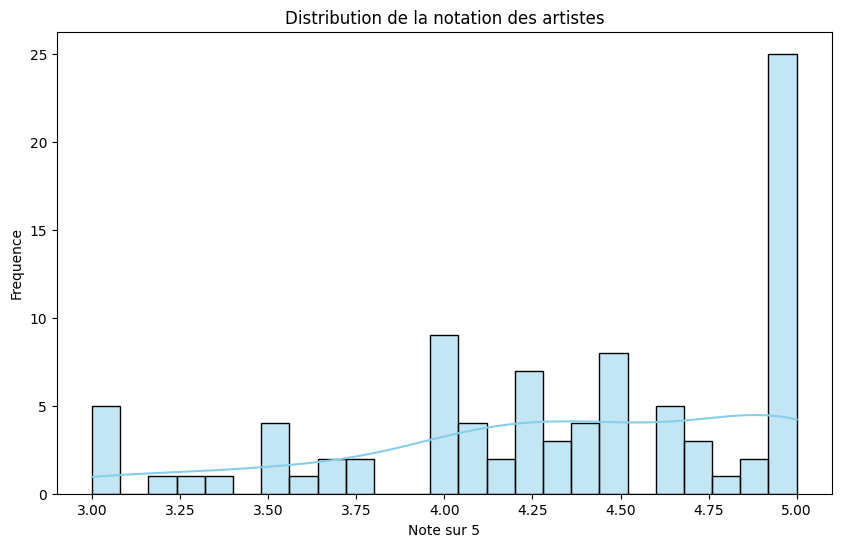

In [11]:
#Histogrammes (visualisation) pour déterminer les tendances

# Histogramme des RatingValue
plt.figure(figsize=(10, 6))
sns.histplot(df_merged['RatingValue'].dropna(), kde=True, bins=25, color='skyblue')
plt.title('Distribution de la notation des artistes')
plt.xlabel('Note sur 5')
plt.ylabel('Frequence')
plt.show()



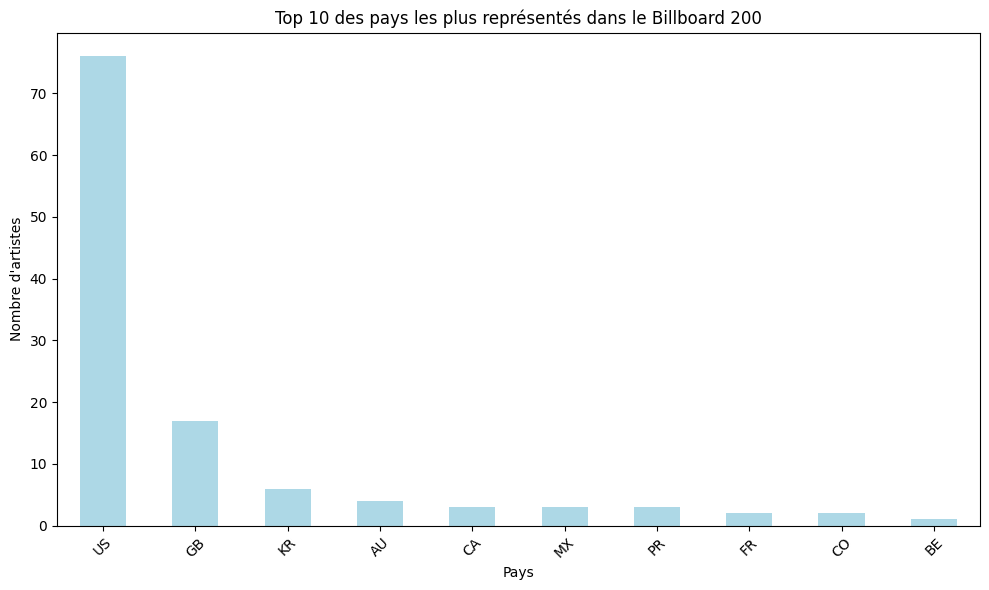

In [12]:
# Les 10 pays les plus représentés
country_counts = df_merged['Country'].value_counts().head(10)  

# Histogramme
plt.figure(figsize=(10, 6))
country_counts.plot(kind='bar', color='lightblue')
plt.title('Top 10 des pays les plus représentés dans le Billboard 200')
plt.xlabel('Pays')
plt.ylabel('Nombre d\'artistes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

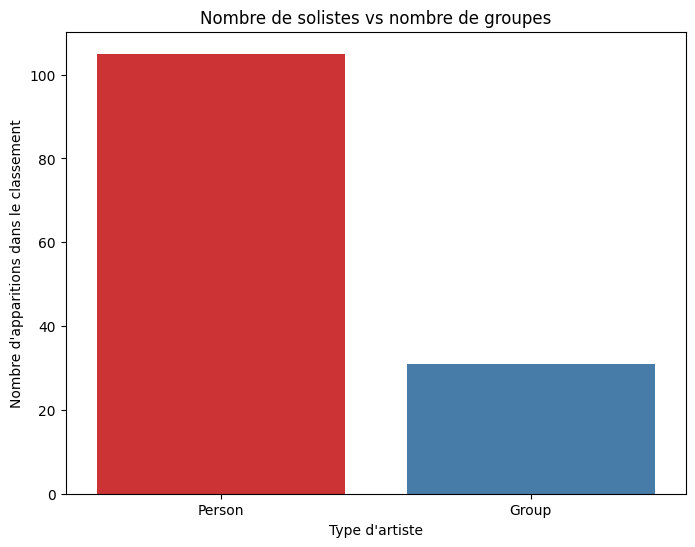

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# On compte le nombre de groupes et de solistes
type_counts = df_merged['Type'].value_counts()

# Le diagramme a barres
plt.figure(figsize=(8, 6))
sns.barplot(x=type_counts.index, y=type_counts.values, hue=type_counts.index,  # Assign x to hue
    palette="Set1", dodge=False)
plt.title('Nombre de solistes vs nombre de groupes')
plt.xlabel("Type d'artiste")
plt.ylabel("Nombre d'apparitions dans le classement")
plt.show()


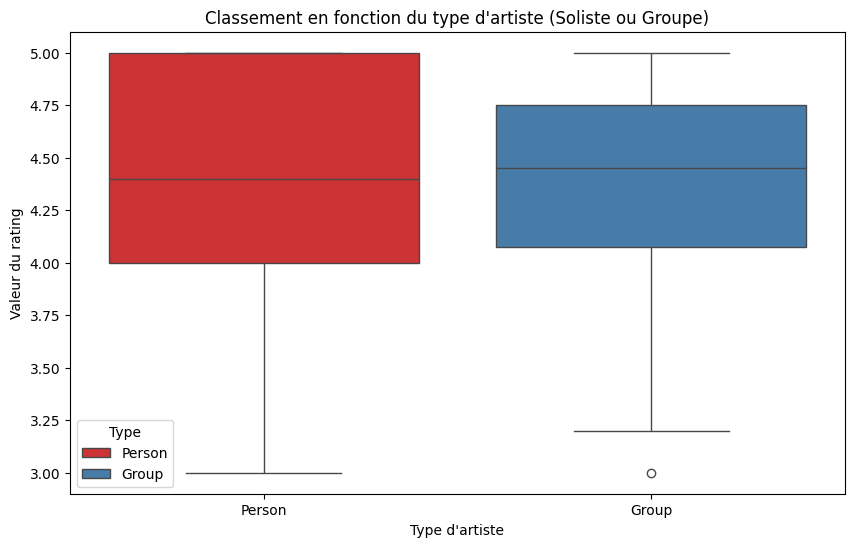

In [14]:
# Box plot pour le type d'artiste
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='RatingValue', data=df_merged, hue='Type', palette="Set1",dodge=False)
plt.title("Classement en fonction du type d'artiste (Soliste ou Groupe)")
plt.xlabel("Type d'artiste")
plt.ylabel('Valeur du rating')
plt.show()


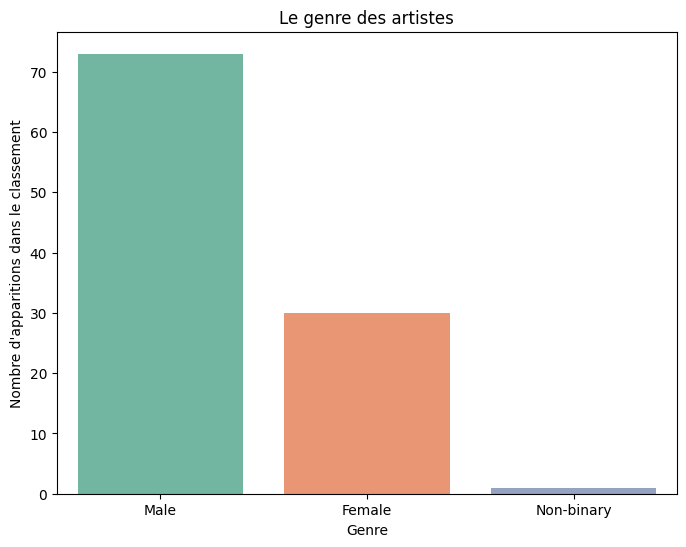

In [15]:
# Le genre des artistes
gender_counts = df_merged['Gender'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=gender_counts.index, y=gender_counts.values, hue=gender_counts.index,palette="Set2", dodge=False)
plt.title('Le genre des artistes')
plt.xlabel('Genre')
plt.ylabel("Nombre d'apparitions dans le classement")
plt.show()


In [17]:
dataframe = fetch_lyrics(dataframe)

100%|██████████| 200/200 [12:53<00:00,  3.87s/it]


Tentative NLP en fonction des paroles des chansons les plus célèbres

In [20]:
from collections import Counter

%run "src/scripts/nltk_script.py"

# Tokenize the lyrics
dataframe['LyricsTokenized'] = dataframe['Lyrics'].apply(tokenize_lyrics)

# Count the occurrences of each word
word_counts = Counter([word for sublist in dataframe['LyricsTokenized'] for word in sublist])

# Print the most common words
word_counts.most_common(10)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('like', 494),
 ('know', 341),
 ('christmas', 317),
 ('love', 313),
 ('baby', 293),
 ('got', 255),
 ('wan', 249),
 ('get', 236),
 ('let', 198),
 ('ca', 183)]

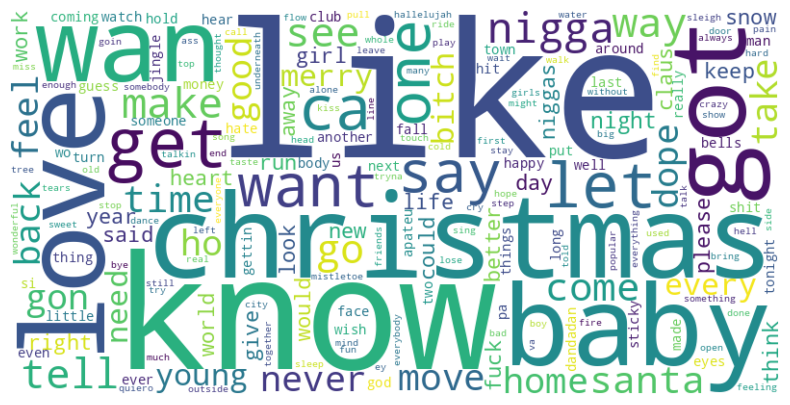

In [21]:
# Generate a word cloud
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Analyse fréquentielle avec SpaCy

In [20]:
#Tokenization et nettoyage des paroles avec spaCy
#Le cadre
import spacy
!python -m spacy download en_core_web_sm
nlp_english = spacy.load("en_core_web_sm")

#tokenisation
def tokenize_lyrics(lyrics):
    doc = nlp_english(lyrics)  
    tokens = [token.text for token in doc]  
    return tokens

df_freq_analysis=dataframe.copy()
df_freq_analysis['Tokens'] = df_freq_analysis['Lyrics'].apply(tokenize_lyrics)


#Nettoyage
import string
def clean_tokens(tokens):
    cleaned_tokens=[]
    for token in tokens:
        token = token.strip()  
        if token not in {"\n", "\n\n", "\n\n\n"} and token not in string.punctuation:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens
df_freq_analysis

df_freq_analysis['Cleaned_Tokens'] = df_freq_analysis['Tokens'].apply(clean_tokens)


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 1.5 MB/s eta 0:00:09
     - -------------------------------------- 0.5/12.8 MB 1.5 MB/s eta 0:00:09
     -- ------------------------------------- 0.8/12.8 MB 1.3 MB/s eta 0:00:10
     --- ------------------------------------ 1.0/12.8 MB 1.1 MB/s eta 0:00:11
     ---- ----------------------------------- 1.3/12.8 MB 1.1 MB/s eta 0:00:11
     ---- ----------------------------------- 1.6/12.8 MB 1.2 MB/s eta 0:00:10
     ----- ---------------------------------- 1.8/12.8 MB 1.2 MB/s eta 0:00:10
     ------ --------------------------------- 2.1/12.8 MB 1.2 MB/s eta 0:00:10
     ------- -------------------------------- 2.4/12.8 MB 1.2 MB/s eta 0:00:09
     -------- ------------------------------- 2.6/12.8 MB 1.2 MB/s 

In [32]:
#Détermination de la durée moyenne des chansons (en termes de mots)
df_freq_analysis['Cleaned_Tokens_Count'] = df_freq_analysis['Cleaned_Tokens'].apply(len)
average_count=df_freq_analysis['Cleaned_Tokens_Count'].mean()
print(f"Le nombre moyen de mots par chanson est {average_count:.2f}")


Le nombre moyen de mots par chanson est 375.86


    Word  Frequency
15     i       3459
38   you       2464
56   the       2164
63     a       1456
58    it       1296
31    me       1284
126  and       1197
11    to       1155
25    's        963
85    my        920


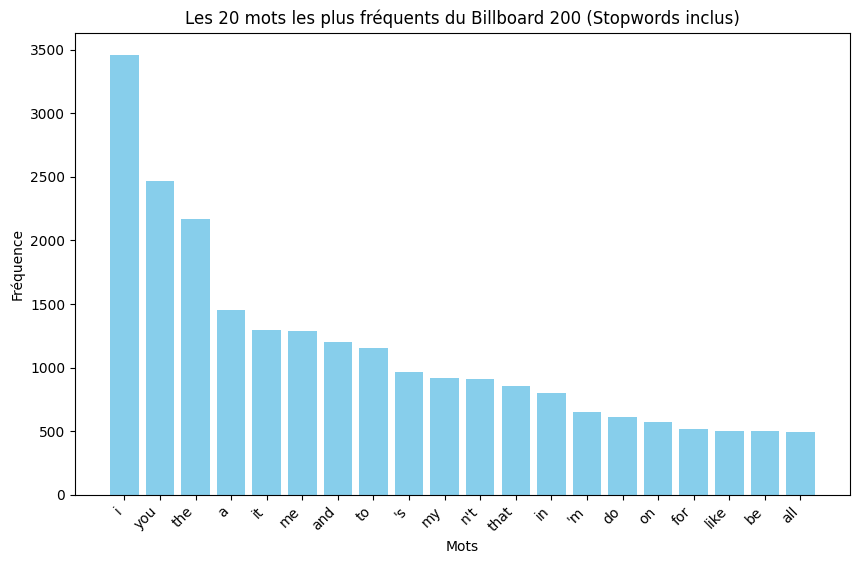

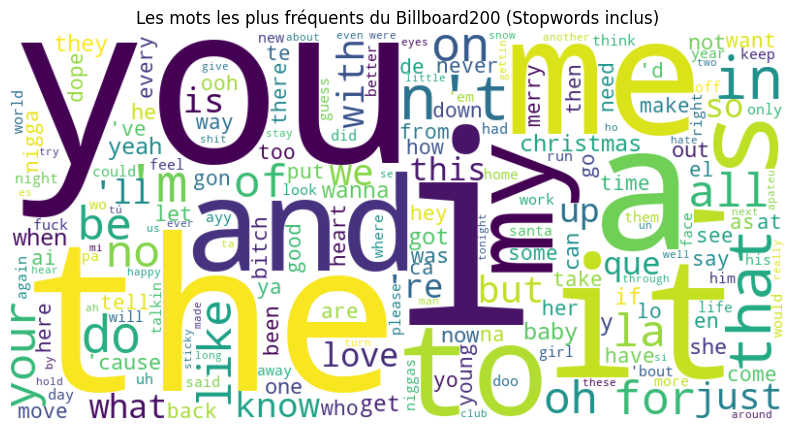

In [ ]:
#Analyse fréquentielle: Recherche des thématiques principales (1/2) 

# 1) Tout d'abord on fait une analyse sans filtre (on n'élimine pas les stopwords)
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Pour faciliter l'analyse, on cree une Series qui regroupe tous les mots de toutes les chansons
all_words = [word for tokens in df_freq_analysis['Cleaned_Tokens'] for word in tokens]

# Nous allons établir la fréquence d'apparition des mots les plus fréquents dans le Billboard200
word_counts = Counter(all_words)
freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
print(freq_df.head(10))

# Création d'un histogramme
top_n = 20  # Rq: on pourra librement modifier ce nombre
top_words = freq_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.bar(top_words['Word'], top_words['Frequency'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title(f'Les {top_n} mots les plus fréquents du Billboard 200 (Stopwords inclus)')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.show()

# Création d'un wordcloud
wordcloud_lyrics = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_lyrics, interpolation='bilinear')
plt.axis('off')
plt.title('Les mots les plus fréquents du Billboard200 (Stopwords inclus)')
plt.show()



    Word  Frequency
15     i       3459
38   you       2464
56   the       2164
63     a       1456
58    it       1296
31    me       1284
126  and       1197
11    to       1155
25    's        963
85    my        920


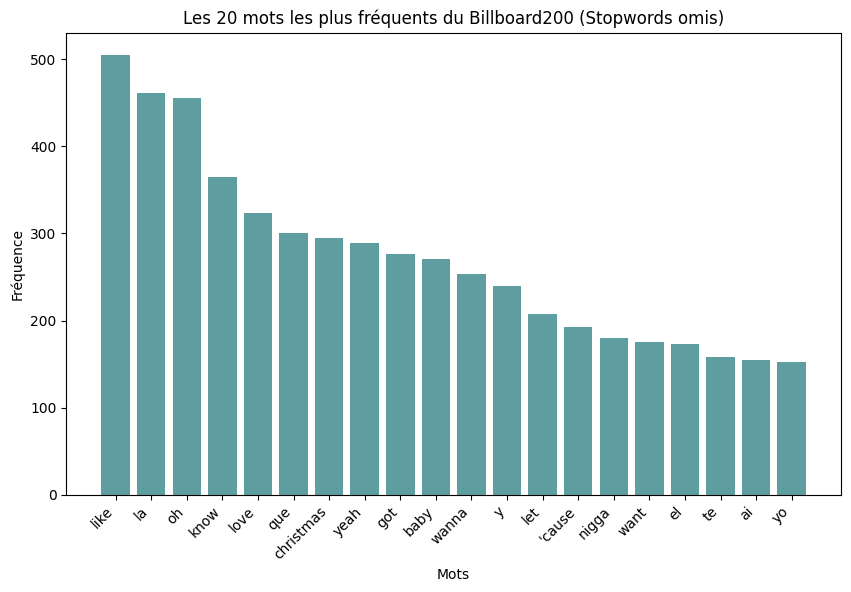

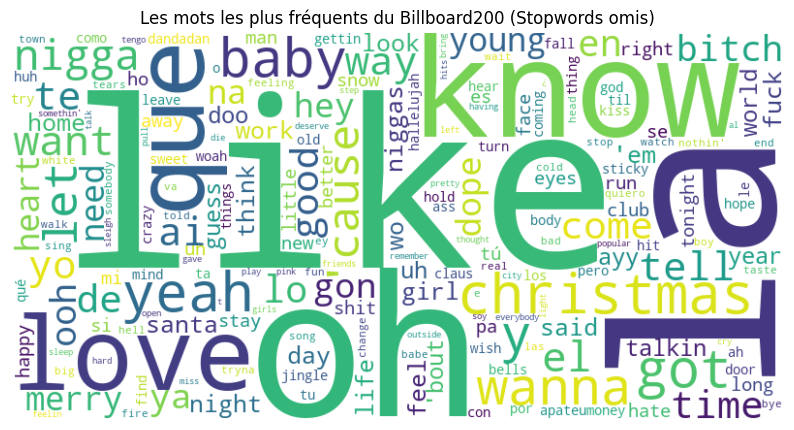

In [22]:
#Analyse fréquentielle: Recherche des thématiques principales (2/2) 

# 2) Nous allons éliminer les stopwords afin de pouvoir déterminer les thématiques les plus présentes dans le Billboard 200. 

stop_words_english = nlp_english.Defaults.stop_words 
all_words_filtered = [word for word in all_words if word.lower() not in stop_words_english]

#Et on procède comme à l'étape précédente
word_counts_filtered = Counter(all_words_filtered)
freq_df_filtered = pd.DataFrame(word_counts_filtered.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
print(freq_df.head(10))

# Création d'un histogramme
top_n = 20  #Rq: on pourra librement modifier ce nombre
top_words_filtered = freq_df_filtered.head(top_n)

plt.figure(figsize=(10, 6))
plt.bar(top_words_filtered['Word'], top_words_filtered['Frequency'], color='cadetblue')
plt.xticks(rotation=45, ha='right')
plt.title(f'Les {top_n} mots les plus fréquents du Billboard200 (Stopwords omis)')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.show()

# Création d'un wordcloud
wordcloud_lyrics_filtered = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts_filtered)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_lyrics_filtered, interpolation='bilinear')
plt.axis('off')
plt.title('Les mots les plus fréquents du Billboard200 (Stopwords omis)')
plt.show()



In [24]:
#Lemmatization (utile pour l'approche bag-of-words)
def lemmatize_tokens(tokens):
    doc=nlp_english(" ".join(tokens))
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop]
    return lemmatized_tokens

#Lemmatization des Series all_words et all_words_filtered
all_words_lemmatized = lemmatize_tokens(all_words)
all_words_filtered_lemmatized = lemmatize_tokens(all_words_filtered)

df_freq_analysis['Lemmas'] = df_freq_analysis['Cleaned_Tokens'].apply(lemmatize_tokens)



In [30]:
#Un dernier graphique: Les 25 "lemmas" les plus récurrents dans le BillBoard200
lemma_counter = Counter(all_words_filtered_lemmatized)
sorted_lemma_counts = lemma_counter.most_common(25)
sorted_lemma_counts_df = pd.DataFrame(sorted_lemma_counts, columns=["Mot", "Nombre d'occurrences"])

# Visualisation: barres pour la représentation des fréquences
def occurrences_bar_graph(data, column):
    max_value = data[column].max()
    bars = data[column].apply(lambda x: f"<div style='width: {x/max_value*100}%; height: 20px; background-color: green;'></div>")
    return bars

sorted_lemma_counts_df["Barre"] = occurrences_bar_graph(sorted_lemma_counts_df, "Nombre d'occurrences")

# Affichage
from IPython.display import display, HTML
display(HTML(sorted_lemma_counts_df.to_html(escape=False, index=False)))


Mot,Nombre d'occurrences,Barre
like,507,
la,461,
oh,455,
know,404,
love,344,
get,305,
christmas,301,
que,300,
yeah,289,
baby,272,


Nous venons de déterminer les mots qui reviennent le plus ce qui sera très utile au moment de générer notre chanson. Nous allons maintenant déterminer les thèmes principaux. Pour cela, nous allons faire les simplifications suivantes: nous allons éliminer les interjections, onomatopées et nous allons uniquement considérer les mots en anglais, étant donnée que c'est la langue dominante du classement. 

In [ ]:
# Recherche des thématiques principales.  (à continuer)

'''
#Fréquences d'apparition d'un mot
freq = pd.DataFrame()
freq['Artist'] = dataframe['Artist']

def count_word_occurrences(tokens, word):
    return tokens.count(word)

#Par exemple avec le mot love
freq['Love_Count'] = dataframe[
    'Cleaned_Tokens'].apply(lambda tokens: count_word_occurrences(tokens, "love")
'''

Analyse de sentiments

In [22]:
# Analyze the sentiment of the lyrics
dataframe['Sentiment'] = dataframe['LyricsTokenized'].apply(analyze_sentiment)

# Divide the sentiment into positive, negative, and neutral
dataframe['Positive'] = dataframe['Sentiment'].apply(lambda x: x['pos'])
dataframe['Negative'] = dataframe['Sentiment'].apply(lambda x: x['neg'])
dataframe['Neutral'] = dataframe['Sentiment'].apply(lambda x: x['neu'])

# Remove the 'Sentiment' column
dataframe.drop(columns=['Sentiment'], inplace=True)

dataframe

,Song,Artist,Lyrics,LyricsTokenized,Positive,Negative,Neutral
0,APT.,"[Rosé, Bruno Mars]",\nChaeyeong-iga\n joh-ahneun\nLaendeom game\nL...,"[laendeom, game, laendeom, game, game, start, ...",0.207,0.054,0.739
1,All I Want For Christmas Is You,[Mariah Carey],\nI don't want a lot for Christmas\nThere is j...,"[want, lot, christmas, one, thing, need, care,...",0.317,0.000,0.683
2,Last Christmas,[Wham!],"\n\nAh, ah-ah\nOoh-woah\nOh-oh\n\nLast Christm...","[last, christmas, gave, heart, next, day, gave...",0.308,0.128,0.564
3,Die With A Smile,"[Lady Gaga, Bruno Mars]","\n\n\nI, I just woke up from a dream\nWhere yo...","[woke, dream, say, goodbye, know, means, since...",0.317,0.160,0.523
4,Rockin' Around The Christmas Tree,[Brenda Lee],\nRockin' around the Christmas tree\nAt the Ch...,"[rockin, around, christmas, tree, christmas, p...",0.392,0.023,0.585
...,...,...,...,...,...,...,...
195,Something Just Like This,"[The Chainsmokers, Coldplay]","\nI've been reading books of old, the legends ...","[reading, books, old, legends, myths, achilles...",0.429,0.050,0.521
196,Dodger Blue,"[Kendrick Lamar, Wallie the Sensei, Siete7x, R...","\nOoh\nOoh\n\nWhite diamonds, 2 a.m., she wild...","[white, diamonds, 2, bitches, sick, got, stoma...",0.086,0.325,0.589
197,Counting Stars,[OneRepublic],"\nLately, I've been, I've been losin' sleep\nD...","[lately, losin, sleep, dreamin, things, could,...",0.071,0.103,0.826
198,Lovely,"[Billie Eilish, Khalid]",\nThought I found a way\nThought I found a way...,"[thought, found, way, thought, found, way, nev...",0.218,0.150,0.632


In [23]:
# Mean of the sentiment scores
print(dataframe[['Positive']].mean())
print(dataframe[['Negative']].mean())
print(dataframe[['Neutral']].mean())

# Display the saddest song
saddest_song = dataframe.loc[dataframe['Negative'].idxmax()]
print("Saddest song:", saddest_song['Song'] + " by " + saddest_song['Artist'][0])
print("Score:", saddest_song['Negative'])

# Display the happiest song
happiest_song = dataframe.loc[dataframe['Positive'].idxmax()]
print("Happiest song:", happiest_song['Song'] + " by " + happiest_song['Artist'][0])
print("Score:", happiest_song['Positive'])

Positive    0.236375
dtype: float64
Negative    0.116085
dtype: float64
Neutral    0.647535
dtype: float64
Saddest song: Ma Meilleure Ennemie by Stromae
Score: 0.448
Happiest song: Merry Christmas by Ed Sheeran
Score: 0.635


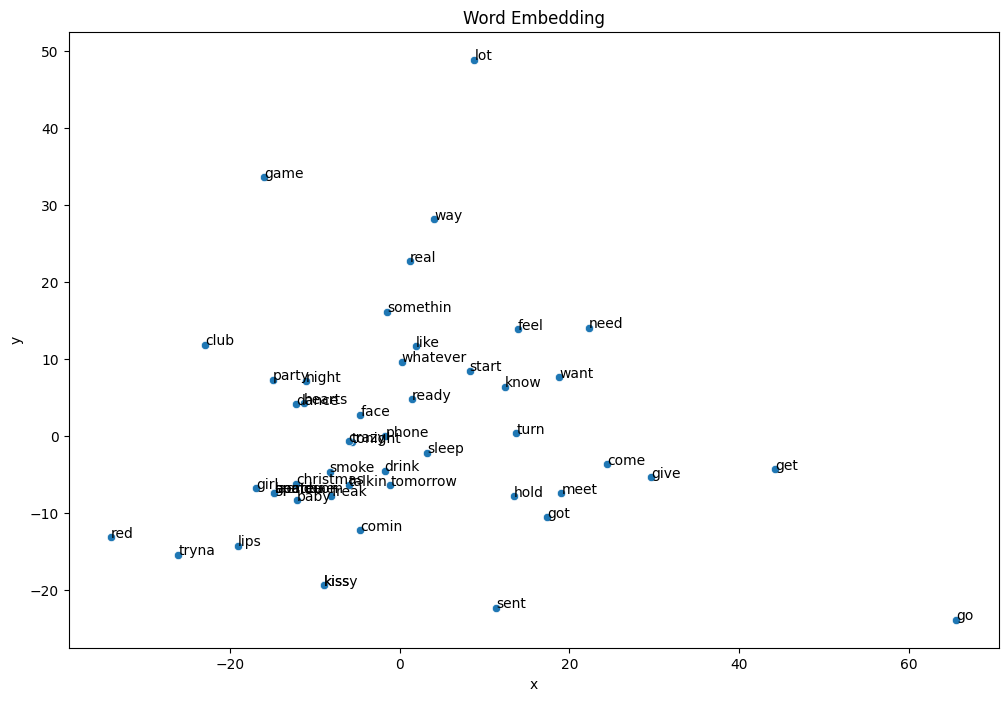

In [24]:
# Word embedding and visualization
import spacy

# Load the pre-trained model
nlp = spacy.load('en_core_web_md')

# Get the vector for the first 100 words
vectors = [nlp(word).vector for word in list(word_counts.keys())[:50]]

# Reduce the dimensionality of the vectors
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

# Create a dataframe
df_vectors = pd.DataFrame(vectors_2d, columns=['x', 'y'])
df_vectors['word'] = list(word_counts.keys())[:50]

# Plot the words with their labels
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_vectors, x='x', y='y')
for i, word in df_vectors.iterrows():
    plt.text(word['x'], word['y'], word['word'])
plt.title('Word Embedding')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [25]:
# For each song, put the five most common words in a list and add them to the dataframe
dataframe['TopWords'] = dataframe['LyricsTokenized'].apply(lambda x: [word for word, count in Counter(x).most_common(5)])

dataframe


,Song,Artist,Lyrics,LyricsTokenized,Positive,Negative,Neutral,TopWords
0,APT.,"[Rosé, Bruno Mars]",\nChaeyeong-iga\n joh-ahneun\nLaendeom game\nL...,"[laendeom, game, laendeom, game, game, start, ...",0.207,0.054,0.739,"[apateu, like, want, need, meet]"
1,All I Want For Christmas Is You,[Mariah Carey],\nI don't want a lot for Christmas\nThere is j...,"[want, lot, christmas, one, thing, need, care,...",0.317,0.000,0.683,"[want, christmas, baby, wo, make]"
2,Last Christmas,[Wham!],"\n\nAh, ah-ah\nOoh-woah\nOh-oh\n\nLast Christm...","[last, christmas, gave, heart, next, day, gave...",0.308,0.128,0.564,"[someone, give, gave, heart, special]"
3,Die With A Smile,"[Lady Gaga, Bruno Mars]","\n\n\nI, I just woke up from a dream\nWhere yo...","[woke, dream, say, goodbye, know, means, since...",0.317,0.160,0.523,"[wan, next, world, ending, night]"
4,Rockin' Around The Christmas Tree,[Brenda Lee],\nRockin' around the Christmas tree\nAt the Ch...,"[rockin, around, christmas, tree, christmas, p...",0.392,0.023,0.585,"[christmas, rockin, around, tree, let]"
...,...,...,...,...,...,...,...,...
195,Something Just Like This,"[The Chainsmokers, Coldplay]","\nI've been reading books of old, the legends ...","[reading, books, old, legends, myths, achilles...",0.429,0.050,0.521,"[something, want, like, wan, somebody]"
196,Dodger Blue,"[Kendrick Lamar, Wallie the Sensei, Siete7x, R...","\nOoh\nOoh\n\nWhite diamonds, 2 a.m., she wild...","[white, diamonds, 2, bitches, sick, got, stoma...",0.086,0.325,0.589,"[walk, bitch, know, first, might]"
197,Counting Stars,[OneRepublic],"\nLately, I've been, I've been losin' sleep\nD...","[lately, losin, sleep, dreamin, things, could,...",0.071,0.103,0.826,"[countin, could, burn, river, money]"
198,Lovely,"[Billie Eilish, Khalid]",\nThought I found a way\nThought I found a way...,"[thought, found, way, thought, found, way, nev...",0.218,0.150,0.632,"[ca, place, mind, hello, welcome]"


In [26]:
# For each tag, find the most common words
tag_words = []
for tag in df_merged['Tags']:
    if tag:
        for word in tag:
            if word not in tag_words:
                tag_words.append(word)
                
print(tag_words)
print(df_merged['Tags'])
                    
# For each tag, find the artists, then the songs, then the most common words
most_common_words = {}
for tag in tag_words:
    artists = df_merged[df_merged['Tags'].apply(lambda x: x is not None and tag in x)]['Artist']
    songs = dataframe[dataframe['Artist'].apply(lambda x: any(artist in x for artist in artists))]['LyricsTokenized']
    words = [word for sublist in songs for word in sublist]
    most_common_words[tag] = Counter(words).most_common(5)
    
most_common_words

['2010s', 'funk', 'music for soccer moms', 'pop', 'r&b', 'relic inn', 'rock', 'soul', '1990s', '2000s', '90s', 'adult contemporary', 'christmas music', 'contemporary r&b', 'dance-pop', 'easy listening', 'english', 'hip hop', 'pop soul', 'quiet storm', 'queer', '2020s', 'americana', 'dance', 'electro house', 'electronic', 'electropop', 'film soundtrack', 'jazz', 'late 2000s', 'pop rock', 'synth-pop', 'synthpop', '2008 universal fire victim', 'american', 'classic pop and rock', 'country', 'rock and roll', 'rockabilly', 'alt-pop', 'alternative pop', 'alternative r&b', 'art pop', 'bedroom pop', 'dark pop', 'indie pop', 'pity pop', 'singer-songwriter', 'trap soul', 'big band', 'country pop', 'standards', 'traditional pop', 'vocal jazz', 'alternative hip hop', 'conscious hip hop', 'hardcore hip hop', 'jazz rap', 'pop rap', 'rap', 'trap', 'west coast hip hop', 'hip hop soul', 'neo soul', 'easy listening soundtracks and musicals', 'australian', 'baroque pop', 'brill building', 'girl group', 'a

{'2010s': [('like', 106),
  ('love', 83),
  ('baby', 80),
  ('know', 63),
  ('apateu', 59)],
 'funk': [('apateu', 59),
  ('like', 43),
  ('know', 17),
  ('wan', 17),
  ('want', 15)],
 'music for soccer moms': [('apateu', 59),
  ('like', 55),
  ('come', 45),
  ('love', 35),
  ('baby', 29)],
 'pop': [('like', 280),
  ('baby', 202),
  ('know', 201),
  ('love', 170),
  ('get', 153)],
 'r&b': [('like', 89),
  ('baby', 73),
  ('know', 62),
  ('apateu', 59),
  ('sticky', 59)],
 'relic inn': [('apateu', 59),
  ('like', 50),
  ('want', 16),
  ('wan', 14),
  ('way', 13)],
 'rock': [('like', 103),
  ('christmas', 69),
  ('apateu', 59),
  ('know', 59),
  ('sticky', 59)],
 'soul': [('like', 69),
  ('apateu', 59),
  ('baby', 46),
  ('want', 45),
  ('know', 38)],
 '1990s': [('bye', 33),
  ('baby', 29),
  ('christmas', 19),
  ('wan', 17),
  ('want', 16)],
 '2000s': [('sticky', 59),
  ('baby', 54),
  ('gettin', 39),
  ('wan', 36),
  ('want', 35)],
 '90s': [('bye', 33),
  ('baby', 29),
  ('christmas', 1